## Caustic plots

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
from shapely.geometry import Polygon
# import phi_q2_ellipticity
from lenstronomy.Util.param_util import phi_q2_ellipticity

# For sampling from caustic
import pointpats

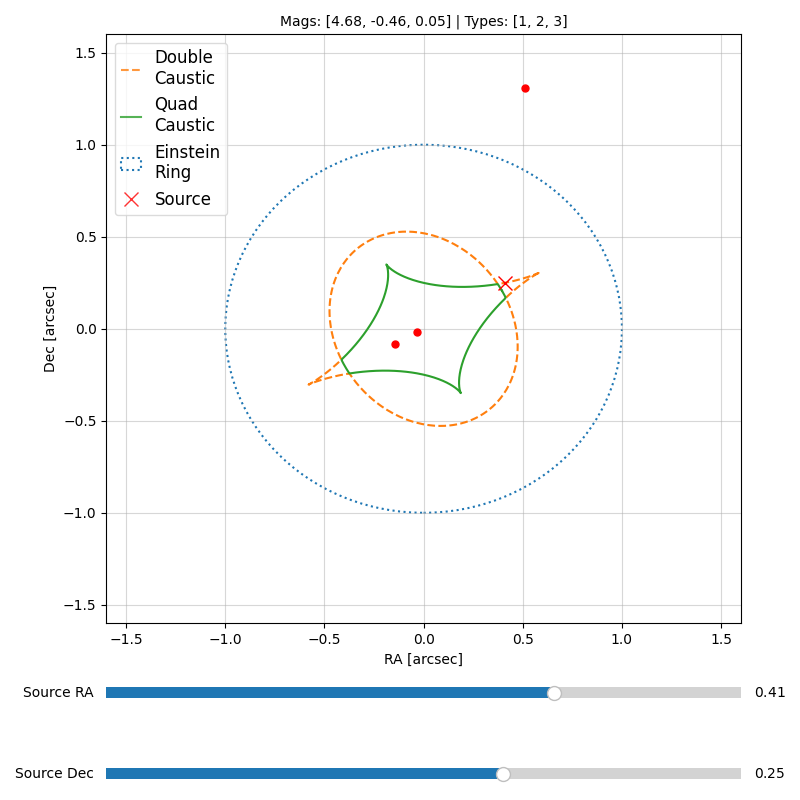

In [16]:
# Interactive caustic plot with sliders
from matplotlib.widgets import Slider

lens_model_list = ["EPL", "SHEAR"]
lensModel = LensModel(lens_model_list=lens_model_list)
lens_eq_solver = LensEquationSolver(lensModel)

# Define parameter values of lens models
idx = 18
q = 0.6
phi = np.pi/6
e1, e2 = phi_q2_ellipticity(phi, q)
kwargs_spep = {
    'theta_E': 1.0,
    'e1': e1,
    'e2': e2,
    'gamma': 1.99-0.149,
    'center_x': 0.0,
    'center_y': 0.0,
}
kwargs_shear = {'gamma1': -0.05, 'gamma2': -0.05}
kwargs_lens = [kwargs_spep, kwargs_shear]

# Initial source position
beta_ra_init, beta_dec_init = 0.41, 0.25

# Create figure with space for sliders
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot2grid((10, 1), (0, 0), rowspan=8)
ax_slider_ra = plt.subplot2grid((10, 1), (8, 0))
ax_slider_dec = plt.subplot2grid((10, 1), (9, 0))

# Plot caustics and Einstein ring (these don't change)
caustic_points = caustics_epl_shear(kwargs_lens, return_which="double", maginf=-100)
ax.plot(caustic_points[0], caustic_points[1], 'C1', linewidth=1.5, linestyle='--', label='Double\nCaustic')
caustic_points = caustics_epl_shear(kwargs_lens, return_which="quad", maginf=-100)
ax.plot(caustic_points[0], caustic_points[1], 'C2', linewidth=1.5, linestyle='-', label='Quad\nCaustic')

# Circle for the Einstein ring
theta_E = 1.0
circle = plt.Circle((0, 0), theta_E, color='C0', fill=False, linestyle='dotted', label='Einstein\nRing', linewidth=1.5)
ax.add_artist(circle)

# Initialize plots for source and images
color = 'r'
source_plot, = ax.plot([], [], marker='x', ls='None', color=color, label='Source', markersize=10)
image_plots, = ax.plot([], [], marker='.', ls='None', color=color, markersize=10)

ax.set_xlabel('RA [arcsec]')
ax.set_ylabel('Dec [arcsec]')

legend = ax.legend(
    handlelength=1.2, 
    loc='upper left', 
    bbox_to_anchor=(0.0, 1.0), 
    frameon=True, 
    fontsize=12, 
    edgecolor='lightgray'
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(1.5)
    handle.set_alpha(0.8)

dim_ = 1.6
ax.set_xlim(-dim_, dim_)
ax.set_ylim(-dim_, dim_)
ax.grid(alpha=0.5)

# Create sliders
slider_ra = Slider(ax_slider_ra, 'Source RA', -1.0, 1.0, valinit=beta_ra_init, valstep=0.01)
slider_dec = Slider(ax_slider_dec, 'Source Dec', -1.0, 1.0, valinit=beta_dec_init, valstep=0.01)

# Update function
def update(val):
    beta_ra = slider_ra.val
    beta_dec = slider_dec.val
    
    try:
        theta_ra, theta_dec = lens_eq_solver.image_position_from_source(
            sourcePos_x=beta_ra, sourcePos_y=beta_dec, kwargs_lens=kwargs_lens,
            solver="analytical", magnification_limit=1.0 / 100.0, arrival_time_sort=True
        )
        magnifications = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)
        
        # Calculate image types
        hessian = lensModel.hessian(theta_ra, theta_dec, kwargs_lens)
        determinant = np.array(
            (1 - hessian[0]) * (1 - hessian[3]) - hessian[1] * hessian[2]
        )
        trace = np.array(2 - hessian[0] - hessian[3])
        
        image_type = []
        # for j in range(len(theta_ra)):
        #     image_type_buffer = 0
        #     if determinant[j] < 0:
        #         image_type_buffer = 2  # Saddle point
        #     else:
        #         if trace[j] > 0:
        #             image_type_buffer = 1  # Minimum
        #         if trace[j] < 0:
        #             image_type_buffer = 3  # Maximum

        #     image_type.append(image_type_buffer)  # Unknown
        for j in range(len(theta_ra)):
            if determinant[j] < 0:
                image_type.append(2)  # Saddle point
            elif trace[j] > 0:
                image_type.append(1)  # Minimum
            elif trace[j] < 0:
                image_type.append(3)  # Maximum
            else:
                image_type.append(0)  # Unknown

        
        # Update source position
        source_plot.set_data([beta_ra], [beta_dec])
        
        # Update image positions
        image_plots.set_data(theta_ra, theta_dec)
        
        # Update title with magnifications and image types
        mag_str = ', '.join([f"{m:.2f}" for m in magnifications])
        type_str = ', '.join([str(int(t)) for t in image_type])
        ax.set_title(f'Mags: [{mag_str}] | Types: [{type_str}]', fontsize=10)
        
    except Exception as e:
        # If solver fails, just update source position
        source_plot.set_data([beta_ra], [beta_dec])
        image_plots.set_data([], [])
        ax.set_title('No valid images found', fontsize=10, color='red')
    
    fig.canvas.draw_idle()

# Connect sliders to update function
slider_ra.on_changed(update)
slider_dec.on_changed(update)

# Initialize the plot
update(None)

plt.tight_layout()
plt.show()